In [159]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from io import StringIO
from pyplotz.pyplotz import PyplotZ

#To show Chinese font
plt.rcParams['font.sans-serif']=['Microsoft YaHei'] 
plt.rcParams['axes.unicode_minus']=False

from matplotlib import font_manager

In [160]:
from sklearn.preprocessing import Imputer
from collections import defaultdict

import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from pprint import pprint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn import svm, ensemble, linear_model, neural_network, neighbors
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from time import time
from functools import partial
from hyperopt import fmin, tpe, hp, space_eval, rand, Trials, partial, STATUS_OK
from sklearn.model_selection import cross_val_score
#from query_variables import query_data

np.random.seed(42)
is_show_roc = True
is_show_feature_importance = True
#search_way = 'grid_search'
#search_way = 'no_search'
search_way = 'bayes_search'
negative_k_folds =7


In [161]:
df_1 = pd.read_csv('C:/Users/310293241/Desktop/datathon/data/data_1.csv',header=None)

In [164]:
# rename columns name 
df_1.rename(columns={0: 'patientunitstayid',1:'unitdischargestatus',
                    2:'gender',3:'age',4:'unitType',5:'apachescore',
                    6:'hospitaladmitoffset',7:'hospitaldischargeoffset',
                    8:'timeInHospital',9:'unabridgedhosplos',
                    10:'unabridgedunitlos',11:'hospitalid',12:'region'}, inplace=True)

In [166]:
df_2 = pd.read_csv('C:/Users/310293241/Desktop/datathon/data/df_v2006.csv',header=None)

In [169]:
#df_2 = df_2.iloc[1:]

In [170]:
# rename columns name 
df_2.rename(columns={0: 'patientunitstayid',1:'lab',
                    2:'lab_values'}, inplace=True)

In [171]:
# convert str to float
df_2['lab_values'] = df_2['lab_values'].astype(float)

In [172]:
#df_2['lab_values'], df_2['values']=df_2['lab_values'].str.split('g', 1).str

In [173]:
# convert table from vertical to hrozinal 
df_2 = df_2.pivot_table(index=['patientunitstayid'], 
                                    columns='lab', 
                                    values='lab_values')

In [174]:
df_2 = df_2.reset_index()

In [175]:
# convert str to float
df_2['patientunitstayid'] = df_2['patientunitstayid'].astype(int)

In [176]:
# drop duplicates
df_2 = df_2.drop_duplicates()

In [178]:
# merge data 
new_df = pd.merge(df_1,df_2,on=['patientunitstayid'],how='left')

In [179]:
new_df.shape

(112303, 26)

In [180]:
new_df.unitdischargestatus.unique()

array(['Alive', 'Expired', nan], dtype=object)

In [181]:
# drop null values
new_df = new_df.dropna(subset=['unitdischargestatus'])

In [182]:
#'Alive':0;'Expired':1
new_df.loc[new_df.unitdischargestatus  == 'Alive', 'unitdischargestatus'] = 0
new_df.loc[new_df.unitdischargestatus  == 'Expired', 'unitdischargestatus'] = 1

In [183]:
#'Female':0;'Male':1
new_df.loc[new_df.gender  == 'Female', 'gender'] = 0
new_df.loc[new_df.gender  == 'Male', 'gender'] = 1

In [184]:
new_df.head()

,patientunitstayid,unitdischargestatus,gender,age,unitType,apachescore,hospitaladmitoffset,hospitaldischargeoffset,timeInHospital,unabridgedhosplos,...,ALT (SGPT),AST (SGOT),CRP,LDH,WBC x 1000,albumin,creatinine,platelets x 1000,total cholesterol,triglycerides
0,141470,0,0,58,Med-Surg ICU,48,-5,10679,10684,7.4194,...,NaN,NaN,NaN,NaN,21.8,NaN,1.96,184.0,NaN,NaN
1,141515,0,0,68,CCU-CTICU,124,-1092,9290,10382,7.2097,...,29.0,84.0,NaN,NaN,10.0,1.0,2.14,30.0,NaN,NaN
2,141895,0,0,84,Neuro ICU,35,-2,5867,5869,4.0757,...,15.0,18.0,NaN,NaN,9.7,2.6,0.91,176.0,NaN,NaN
3,141923,0,0,55,Med-Surg ICU,47,-13798,350,14148,9.8250,...,NaN,NaN,NaN,NaN,18.1,NaN,1.37,289.0,NaN,NaN
4,142096,0,1,54,Med-Surg ICU,41,-2,3668,3670,2.5486,...,39.0,120.0,NaN,NaN,5.2,2.3,0.79,74.0,NaN,NaN


In [29]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112298 entries, 0 to 112302
Data columns (total 26 columns):
patientunitstayid          112298 non-null int64
unitdischargestatus        112298 non-null int64
gender                     112287 non-null object
age                        112291 non-null object
unitType                   112298 non-null object
apachescore                112298 non-null int64
hospitaladmitoffset        112298 non-null int64
hospitaldischargeoffset    112298 non-null int64
timeInHospital             112298 non-null int64
unabridgedhosplos          112298 non-null float64
unabridgedunitlos          112298 non-null float64
hospitalid                 112298 non-null int64
region                     106764 non-null object
-lymphs                    71363 non-null float64
-monos                     70880 non-null float64
-polys                     63813 non-null float64
ALT (SGPT)                 61136 non-null float64
AST (SGOT)                 61472 non-null fl

In [35]:
# crp sumary
new_df['CRP'].describe()

count    3993.000000
mean       39.883853
std        69.788076
min         0.000000
25%         4.010000
50%        12.400000
75%        30.900000
max       577.800000
Name: CRP, dtype: float64

In [36]:
# albumin summary
new_df['albumin'].describe()

count    65558.000000
mean         2.870120
std          0.944412
min          0.400000
25%          2.400000
50%          2.900000
75%          3.300000
max        100.000000
Name: albumin, dtype: float64

In [37]:
#print (new_df['CRP']>0.8).value_counts())
#print (new_df['CRP']==0.0).value_counts()

False    108588
True       3710
Name: CRP, dtype: int64

In [39]:
# drop zero values
new_df_1 = new_df[new_df['CRP']!=0.0]

In [41]:
new_df_1.shape

(112286, 26)

In [42]:
columns = ['age','apachescore','hospitaladmitoffset','hospitaldischargeoffset','timeInHospital','unabridgedhosplos',
       'unabridgedunitlos','-lymphs','-monos','-polys','ALT (SGPT)', 'AST (SGOT)','CRP','LDH','WBC x 1000',
          'albumin','creatinine','platelets x 1000','total cholesterol','triglycerides']

In [43]:
# convert albumin from str to float
new_df_1['albumin'] = new_df_1['albumin'].astype(float)

In [48]:
# drop zero values
new_df_2 = new_df_1[new_df_1['albumin']!=0.0]

In [50]:
# compute crp/alb
new_df_2['crp_alb'] = (new_df_2.CRP/new_df_2['albumin'])

In [51]:
new_df_2['crp_alb'].describe()

count    2876.000000
mean       20.105129
std        34.984671
min         0.005882
25%         2.152422
50%         6.096875
75%        17.663961
max       284.285714
Name: crp_alb, dtype: float64

In [52]:
# drop age >89 patients
new_df_3 =new_df_2[new_df_2['age']!='> 89']

In [53]:
new_df_3.age.value_counts()

67    2737
71    2602
66    2592
68    2577
72    2539
70    2522
65    2517
64    2438
63    2432
62    2391
73    2380
61    2357
60    2333
59    2313
57    2302
56    2294
74    2288
75    2273
69    2260
77    2258
55    2253
76    2241
58    2162
78    2152
54    2062
79    2060
53    1975
80    1915
81    1892
52    1865
      ... 
34     674
32     626
30     608
24     576
26     568
27     565
31     554
28     536
25     521
21     512
29     500
23     486
22     483
19     453
20     423
18     335
17     162
16      79
15      41
14      17
13      11
12       6
0        5
11       4
9        3
7        2
10       2
8        2
1        1
4        1
Name: age, Length: 86, dtype: int64

In [55]:
# drop null values from age
new_df_3 = new_df_3.dropna(subset=['age'])

In [56]:
new_df_3.age = new_df_3.age.astype(int)

In [57]:
data = pd.read_csv("C:/Users/310293241/Desktop/datathon/data/560.csv",encoding='utf-8')

In [59]:
data.head()

,Unnamed: 0,V1,pipeihaoma,patientunitstayid,unitdischargestatus,gender,age,unitType,apachescore,hospitaladmitoffset,...,x,@1000,total,cholesterol,triglycerides,crp_alb,ps,pipei,time,three_qua
0,0,55978,1,141297,1,1,63,SICU,86,-8174,...,,,,,,8.208333,0.194413,153938,1,2
1,1,84700,2,199499,1,0,77,SICU,87,-10,...,,,,,,3.481481,0.184099,141362,1,2
2,2,42430,3,208829,1,0,81,Med-Surg,ICU,68,...,,,,,,0.146341,0.098459,167518,1,1
3,3,99216,4,260998,1,1,64,Med-Surg,ICU,151,...,,,,,,26.000000,0.099884,268435,1,3
4,4,42904,5,313744,1,0,31,Med-Surg,ICU,26,...,,,,,,4.665217,0.044398,265546,1,2


In [60]:
data.rename(columns={'三分位数': 'three_qua','ps倾向性评分':'ps'}, inplace=True)

In [61]:
data.to_csv("C:/Users/310293241/Desktop/datathon/data/560.csv",encoding='utf-8')

1.crp/alb 辑回归连续变量
2. 三分位数


In [62]:
import statsmodels.api as sm

In [204]:
# signal variable
logit_model=sm.Logit(data['unitdischargestatus'],data['crp_alb'])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.672244
         Iterations 5
                          Results: Logit
Model:              Logit               Pseudo R-squared: 0.030   
Dependent Variable: unitdischargestatus AIC:              754.9137
Date:               2019-11-17 10:39    BIC:              759.2417
No. Observations:   560                 Log-Likelihood:   -376.46 
Df Model:           0                   LL-Null:          -388.16 
Df Residuals:       559                 LLR p-value:      nan     
Converged:          1.0000              Scale:            1.0000  
No. Iterations:     5.0000                                        
---------------------------------------------------------------------
           Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
---------------------------------------------------------------------
crp_alb    0.0126      0.0029    4.2979    0.0000    0.0069    0.0183



In [205]:
import math
math.exp(0.0126)

1.0126797144488495

In [206]:
# 95% CI level
params = result.params
conf=result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%','OR']
np.exp(conf)

,2.5%,97.5%,OR
crp_alb,1.006879,1.018518,1.012682


In [152]:
data.head()

,Unnamed: 0,V1,pipeihaoma,patientunitstayid,unitdischargestatus,gender,age,unitType,apachescore,hospitaladmitoffset,...,x,@1000,total,cholesterol,triglycerides,crp_alb,ps,pipei,time,three_qua
0,0,55978,1,141297,1,1,63,SICU,86,-8174,...,,,,,,8.208333,0.194413,153938,1,2
1,1,84700,2,199499,1,0,77,SICU,87,-10,...,,,,,,3.481481,0.184099,141362,1,2
2,2,42430,3,208829,1,0,81,Med-Surg,ICU,68,...,,,,,,0.146341,0.098459,167518,1,1
3,3,99216,4,260998,1,1,64,Med-Surg,ICU,151,...,,,,,,26.000000,0.099884,268435,1,3
4,4,42904,5,313744,1,0,31,Med-Surg,ICU,26,...,,,,,,4.665217,0.044398,265546,1,2


In [156]:
df_icu= data[data['apachescore']=='ICU']
df_no_icu = data[data['apachescore']!='ICU']
df_no_icu['apachescore'] = df_no_icu['apachescore'].astype(float)
df_no_icu['apachescore'] = abs(df_no_icu['apachescore'])
df_icu.loc[df_icu.apachescore  == 'ICU', 'apachescore'] = 70.02765
data = pd.concat ([df_icu,df_no_icu])

In [157]:
data['apachescore'] = data['apachescore'].astype(float)

In [158]:
# multi_varibales
# crp_alb, age
cols=['crp_alb', 'apachescore'] 
X=data[cols]
y=data['unitdischargestatus']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.671150
         Iterations 5
                           Results: Logit
Model:              Logit               Pseudo R-squared: 0.032     
Dependent Variable: unitdischargestatus AIC:              755.6877  
Date:               2019-11-17 09:59    BIC:              764.3436  
No. Observations:   560                 Log-Likelihood:   -375.84   
Df Model:           1                   LL-Null:          -388.16   
Df Residuals:       558                 LLR p-value:      6.9206e-07
Converged:          1.0000              Scale:            1.0000    
No. Iterations:     5.0000                                          
----------------------------------------------------------------------
               Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
----------------------------------------------------------------------
crp_alb        0.0146     0.0035    4.1303   0.0000    0.0076   0.0215
apachescore   -0.001

In [186]:
params = result.params
conf=result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%','OR']
np.exp(conf)

,2.5%,97.5%,OR
crp_alb,1.007676,1.021689,1.014658
apachescore,0.995794,1.001176,0.998481


In [150]:
# multi_varibales
# crp_alb, age, gender
cols=['crp_alb','gender'] 
X=data[cols]
y=data['unitdischargestatus']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.670222
         Iterations 5
                           Results: Logit
Model:              Logit               Pseudo R-squared: 0.033     
Dependent Variable: unitdischargestatus AIC:              754.6488  
Date:               2019-11-17 09:44    BIC:              763.3047  
No. Observations:   560                 Log-Likelihood:   -375.32   
Df Model:           1                   LL-Null:          -388.16   
Df Residuals:       558                 LLR p-value:      4.0381e-07
Converged:          1.0000              Scale:            1.0000    
No. Iterations:     5.0000                                          
----------------------------------------------------------------------
               Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
----------------------------------------------------------------------
crp_alb        0.0145     0.0033    4.4163   0.0000    0.0081   0.0209
gender        -0.182

In [151]:
params = result.params
conf=result.conf_int()
conf['OR'] = params
conf.columns = ['2.5%','97.5%','OR']
np.exp(conf)

,2.5%,97.5%,OR
crp_alb,1.008085,1.021123,1.014583
gender,0.657079,1.057140,0.833442


In [66]:
data['three_qua'].unique()

array([2, 1, 3], dtype=int64)

In [68]:
# group 1 as reference to compare
dff_1  = data [(data ['three_qua']!=3)]

In [69]:
#1:2
# group 1 as reference to compare
logit_model=sm.Logit(dff_1['unitdischargestatus'],dff_1['three_qua'])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.684884
         Iterations 4
                          Results: Logit
Model:              Logit               Pseudo R-squared: -0.008  
Dependent Variable: unitdischargestatus AIC:              514.2932
Date:               2019-11-16 22:44    BIC:              518.2174
No. Observations:   374                 Log-Likelihood:   -256.15 
Df Model:           0                   LL-Null:          -254.07 
Df Residuals:       373                 LLR p-value:      nan     
Converged:          1.0000              Scale:            1.0000  
No. Iterations:     4.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
three_qua      -0.1633    0.0660  -2.4722  0.0134  -0.2927  -0.0338



In [70]:
math.exp(-0.1633)

0.8493363492858464

In [71]:
# 1:3
# group 1 as reference to compare
dff_2 = data[data['three_qua']!=2]
logit_model=sm.Logit(dff_2['unitdischargestatus'],dff_2['three_qua'])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.679280
         Iterations 4
                          Results: Logit
Model:              Logit               Pseudo R-squared: 0.019   
Dependent Variable: unitdischargestatus AIC:              507.3844
Date:               2019-11-16 22:44    BIC:              511.3033
No. Observations:   372                 Log-Likelihood:   -252.69 
Df Model:           0                   LL-Null:          -257.59 
Df Residuals:       371                 LLR p-value:      nan     
Converged:          1.0000              Scale:            1.0000  
No. Iterations:     4.0000                                        
--------------------------------------------------------------------
               Coef.    Std.Err.     z      P>|z|    [0.025   0.975]
--------------------------------------------------------------------
three_qua      0.1507     0.0475   3.1752   0.0015   0.0577   0.2437



In [72]:
math.exp(  0.1507 )

1.1626478114140122

In [73]:
#
dff_3 = data[data['three_qua']!=3]
logit_model=sm.Logit(dff_3['unitdischargestatus'],dff_3['three_qua'])
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.684884
         Iterations 4
                          Results: Logit
Model:              Logit               Pseudo R-squared: -0.008  
Dependent Variable: unitdischargestatus AIC:              514.2932
Date:               2019-11-16 22:44    BIC:              518.2174
No. Observations:   374                 Log-Likelihood:   -256.15 
Df Model:           0                   LL-Null:          -254.07 
Df Residuals:       373                 LLR p-value:      nan     
Converged:          1.0000              Scale:            1.0000  
No. Iterations:     4.0000                                        
-------------------------------------------------------------------
                Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------------------------------------------
three_qua      -0.1633    0.0660  -2.4722  0.0134  -0.2927  -0.0338



In [74]:
math.exp( -0.1633)

0.8493363492858464

In [77]:
#new_df_3.to_csv('case_study_data.csv')

In [79]:
new_df_3.head()

,patientunitstayid,unitdischargestatus,gender,age,unitType,apachescore,hospitaladmitoffset,hospitaldischargeoffset,timeInHospital,unabridgedhosplos,...,AST (SGOT),CRP,LDH,WBC x 1000,albumin,creatinine,platelets x 1000,total cholesterol,triglycerides,crp_alb
0,141470,0,0,58,Med-Surg ICU,48,-5,10679,10684,7.4194,...,NaN,NaN,NaN,21.8,NaN,1.96,184.0,NaN,NaN,NaN
1,141515,0,0,68,CCU-CTICU,124,-1092,9290,10382,7.2097,...,84.0,NaN,NaN,10.0,1.0,2.14,30.0,NaN,NaN,NaN
2,141895,0,0,84,Neuro ICU,35,-2,5867,5869,4.0757,...,18.0,NaN,NaN,9.7,2.6,0.91,176.0,NaN,NaN,NaN
3,141923,0,0,55,Med-Surg ICU,47,-13798,350,14148,9.8250,...,NaN,NaN,NaN,18.1,NaN,1.37,289.0,NaN,NaN,NaN
4,142096,0,1,54,Med-Surg ICU,41,-2,3668,3670,2.5486,...,120.0,NaN,NaN,5.2,2.3,0.79,74.0,NaN,NaN,NaN


In [80]:
data.head()

,Unnamed: 0,V1,pipeihaoma,patientunitstayid,unitdischargestatus,gender,age,unitType,apachescore,hospitaladmitoffset,...,x,@1000,total,cholesterol,triglycerides,crp_alb,ps,pipei,time,three_qua
0,0,55978,1,141297,1,1,63,SICU,86,-8174,...,,,,,,8.208333,0.194413,153938,1,2
1,1,84700,2,199499,1,0,77,SICU,87,-10,...,,,,,,3.481481,0.184099,141362,1,2
2,2,42430,3,208829,1,0,81,Med-Surg,ICU,68,...,,,,,,0.146341,0.098459,167518,1,1
3,3,99216,4,260998,1,1,64,Med-Surg,ICU,151,...,,,,,,26.000000,0.099884,268435,1,3
4,4,42904,5,313744,1,0,31,Med-Surg,ICU,26,...,,,,,,4.665217,0.044398,265546,1,2


In [81]:
import sklearn.metrics as metrics

In [82]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
col = {
        'gender': 'gender',
        'age': 'age',
        'apachescore': 'apachescore',
        'crp_alb': 'crp_alb'
    }
df_death = data[data['unitdischargestatus']==1]
df_death['unitdischargestatus'] = 1
df_alive = data[data['unitdischargestatus']==0]
df_alive['unitdischargestatus'] = 0
df = pd.concat([df_death,df_alive])
df = df[['gender','age','apachescore','crp_alb','unitdischargestatus']]
    
    
    #del df_hii['Unnamed: 0']
   # del df_hii['index'] 
    #del df_hii['Label_HII']
    #del df_nohii['Unnamed: 0']
    #del df_nohii['index'] 
    #del df_nohii['Label_HII']
    
df_icu= df[df['apachescore']=='ICU']
df_no_icu = df[df['apachescore']!='ICU']
df_no_icu['apachescore'] = df_no_icu['apachescore'].astype(float)
df_no_icu['apachescore'] = abs(df_no_icu['apachescore'])
df_icu.loc[df_icu.apachescore  == 'ICU', 'apachescore'] = 70.02765
df = pd.concat([df_icu,df_no_icu])
    #col_list = ['bp_s_i','bp_s','hr','bun','abe','hematocrit','wbc-leukocyte','co2','creatinine','fio2','paco2',
            #'temp_degc','hemoglobin','shock_idx','age','HII']
    
df = df.astype('float')
    
    #final_df = final_df[columns].astype('float')
    #collist = df.columns[:-1].values
    #X = df.iloc[:, :-1].values
    #y = df.iloc[:, -1].values

In [100]:
#inp_df = df[['gender','age','apachescore','crp_alb']]
#out_df = df[['unitdischargestatus']]

## split tarin and text data
#X_train, X_test, y_train, y_test = train_test_split(inp_df, out_df, test_size=0.2, random_state=42)

In [191]:
# builde model 
class BayesSearchCV(object):
    def __init__(self, X_train, y_train, build_model, space):
        self.X_train = X_train
        self.y_train = y_train
        self.build_model = build_model
        self.space = space

    def model_metric(self, argsDict):
        model = self.build_model(argsDict)
        metric = cross_val_score(model, self.X_train, self.y_train, cv=2, scoring="roc_auc").mean()
        return -metric

    def fit(self):
        algo = partial(tpe.suggest, n_startup_jobs=1)
        best = fmin(self.model_metric, self.space, algo=algo, max_evals=4,
                    rstate=np.random.RandomState(42))
        model = self.build_model(best)
        model.fit(self.X_train, self.y_train)
        return model


def logistic_regression_model():
    if search_way in ['grid_search', 'no_search']:
        model = linear_model.LogisticRegression(C=1.0, penalty='l1', solver='saga', multi_class='multinomial',
                                                class_weight='balanced')
        param_grid = [
            {'C': np.logspace(1, 3, 3)}
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            return linear_model.LogisticRegression(C=argsDict["C"], penalty='l1', solver='saga',
                                                   multi_class='multinomial', class_weight='balanced')

        space = {"C": hp.uniform("C", 0, 10),
                 # "max_iter": hp.randint("max_iter", 300),
                 # "penalty": hp.choice("penalty", ['l2']),  #'l1', 'elasticnet',,  'none']
                 # "solver": hp.choice("solver", {'newton-cg', 'lbfgs', 'sag', 'saga'}),  # 'liblinear'
                 # "multi_class": hp.choice("multi_class", {'ovr', 'multinomial'}),
                 }
        return build_model, space


def svc_model():
    if search_way in ['grid_search', 'no_search']:
        model = svm.SVC(gamma=0.001, C=0.0001, probability=True, class_weight='balanced')
        param_grid = [
            {'gamma': np.logspace(-4, -2, 3), 'C': np.logspace(5, 7, 3)}
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            return svm.SVC(gamma=argsDict['gamma'], C=argsDict['C'],
                           # kernel=argsDict['kernel'], degree=argsDict['degree'],
                           # coef0=argsDict['coef0'],
                           probability=True, class_weight='balanced')

        space = {"C": hp.uniform("C", 0, 1000000),
                 'gamma': hp.uniform("gamma", 0, 0.0001),
                 # 'kernel': hp.choice("kernel", ['poly', 'rbf', 'sigmoid']),
                 # 'degree': hp.randint("degree", 8),
                 # 'coef0': hp.uniform("coef0", 0, 10),
                 }
        return build_model, space


def random_forest_model():
    if search_way in ['grid_search', 'no_search']:
        model = ensemble.RandomForestClassifier(class_weight='balanced')
        param_grid = [
            {'n_estimators': [10, 100, 500, 1000], 'max_features': ['auto', 'sqrt'], },
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            return ensemble.RandomForestClassifier(class_weight='balanced',
                                                   n_estimators=argsDict["n_estimators"],
                                                   # max_features=argsDict["max_features"],
                                                   # max_depth=argsDict["max_depth"],
                                                   # min_samples_split=argsDict["min_samples_split"],
                                                   # min_samples_leaf=argsDict["min_samples_leaf"],
                                                   # max_leaf_nodes=argsDict["max_leaf_nodes"],
                                                   )

        space = {'n_estimators': hp.randint("n_estimators", 300),
                 # 'max_features': hp.choice("max_features", ['auto', 'sqrt', 'log2', None]),
                 # 'max_depth': hp.choice("max_depth", range(1, 200)),
                 # 'min_samples_split': hp.choice("min_samples_split", range(3, 10)),
                 # 'min_samples_leaf': hp.choice("min_samples_leaf", range(1, 10)),
                 # 'max_leaf_nodes': hp.choice("max_leaf_nodes", range(1, 100)),
                 # 'min_impurity_decrease': hp.randint("min_impurity_decrease", 10),
                 }
        return build_model, space


def xgboost_model():
    if search_way in ['grid_search', 'no_search']:
        other_params = {
            'reg_alpha': 3, 'reg_lambda': 3
        }
        model = XGBClassifier(class_weight='balanced', **other_params)
        param_grid = [
            {'n_estimators': [100, 500, 1000], 'max_depth': [4, 5, 6], 'min_child_weight': [1, 3, 5],
             'gamma': [0, 0.5, 1]}
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            return XGBClassifier(nthread=4,  # steps
                                 max_depth=argsDict["max_depth"],  # max_depth
                                 n_estimators=argsDict['n_estimators'],  # num trees
                                 learning_rate=argsDict["learning_rate"],  # learning rate
                                 subsample=argsDict["subsample"],  # num subsample
                                 colsample_bytree=argsDict["colsample_bytree"],
                                 min_child_weight=argsDict["min_child_weight"],  # child num
                                 max_delta_step=10,  # 10步不降则停止
                                 gamma=argsDict["gamma"],
                                 # objective="binary:logistic"
                                 # reg_alpha=argsDict["reg_alpha"],
                                 # reg_lambda=argsDict["reg_lambda"],
                                 class_weight='balanced'
                                 )

        space = {"max_depth": hp.randint("max_depth", 10),
                 "n_estimators": hp.randint("n_estimators", 180),  # [0,1,2,3,4,5] -> [50,]
                 "learning_rate": hp.uniform("learning_rate", 0.01, 0.2),  # [0,1,2,3,4,5] -> 0.05,0.06
                 "subsample": hp.uniform("subsample", 0.5, 1),  # [0,1,2,3] -> [0.7,0.8,0.9,1.0]
                 "min_child_weight": hp.uniform("min_child_weight", 0.5, 8),  #
                 "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
                 "gamma": hp.uniform("gamma", 0, 1),
                 # "reg_alpha": hp.uniform("reg_alpha", 0, 4),
                 # "reg_lambda": hp.uniform("reg_lambda", 0, 4)
                 }
        return build_model, space


def mlp_model():
    if search_way in ['grid_search', 'no_search']:
        model = neural_network.MLPClassifier()
        param_grid = [
            {'hidden_layer_sizes': [100, 500, 1000], 'alpha': [10.0 ** i for i in range(-5, 1)]}
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            activations = ['identity', 'logistic', 'tanh', 'relu']
            solvers = ['lbfgs', 'sgd', 'adam']

            activation = argsDict['activation']
            if isinstance(activation, int):
                argsDict['activation'] = activations[activation]
            solver = argsDict['solver']
            if isinstance(solver, int):
                argsDict['solver'] = solvers[solver]
            return neural_network.MLPClassifier(alpha=argsDict['alpha'],
                                                hidden_layer_sizes=argsDict['hidden_layer_sizes'],
                                                activation=argsDict['activation'],
                                                solver=argsDict['solver'],
                                                momentum=argsDict['momentum'],
                                                )

        space = {
            'hidden_layer_sizes': hp.randint("hidden_layer_sizes", 500),
            'alpha': hp.uniform("alpha", 0, 0.1),
            'activation': hp.choice("activation", ['identity', 'logistic', 'tanh', 'relu']),
            'solver': hp.choice("solver", ['lbfgs', 'sgd', 'adam']),
            'momentum': hp.uniform('momentum', 0, 1),
        }
        return build_model, space


def knn_model():
    if search_way in ['grid_search', 'no_search']:
        model = neighbors.KNeighborsClassifier()
        param_grid = [
            {'n_neighbors': [i for i in range(1, 10)], 'weights': ['uniform', 'distance']}
        ]
        return model, param_grid

    if search_way == 'bayes_search':
        def build_model(argsDict):
            algorithms = ["auto", "ball_tree", "kd_tree", "brute"]
            weights = ["uniform", "distance"]

            algorithm = argsDict['algorithm']
            if isinstance(algorithm, int):
                argsDict['algorithm'] = algorithms[algorithm]
            weight = argsDict['weights']
            if isinstance(weight, int):
                argsDict['weights'] = weights[weight]
            return neighbors.KNeighborsClassifier(n_neighbors=argsDict['n_neighbors'],
                                                  weights=argsDict['weights'],  # argsDict['weights'],
                                                  algorithm=argsDict['algorithm'],
                                                  # p=argsDict['p']
                                                  )
        space = {
            'n_neighbors': hp.choice("n_neighbors", range(1, 20)),
            'algorithm': hp.choice('algorithm', ["auto", "ball_tree", "kd_tree", "brute"]),
            'weights': hp.choice("weights", ["uniform", "distance"]),
            # 'p': hp.choice('p', range(1, 5)),
        }
        return build_model, space


class ImbalanceClassifier(object):
    def __init__(self, X_train, y_train, X_test, y_test, build_model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.build_model = build_model
        self.negative_k_folds = negative_k_folds

    def preprocess(self):
        # fill na
        imputer = Imputer(strategy="median")
        imputer.fit(self.X_train)
        self.X_train, self.X_test = imputer.transform(self.X_train), imputer.transform(self.X_test)

        # normalize features
        scaler = MinMaxScaler()
        # scaler = StandardScaler()
        scaler.fit(self.X_train)
        self.X_train, self.X_test = scaler.transform(self.X_train), scaler.transform(self.X_test)

    def calc_model_performance(self):
        y_test = self.y_test
        self.preprocess()

        # print('train model...')
        y_predict_all, y_predict_score_all, feature_importants = self.build_imbalance_model()

        true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_test, y_predict_all).ravel()
        specificity = true_negative / (true_negative + false_positive)
        # sensitivity = true_positive / (true_positive + false_negative)

        score = {
            'accuracy': accuracy_score(y_test, y_predict_all),
            'precision': precision_score(y_test, y_predict_all, average='macro'),
            'recall': recall_score(y_test, y_predict_all, average='macro'),
            'f1_score': f1_score(y_test, y_predict_all, average='macro'),
            # 'confusion_matrix': confusion_matrix(y_test, y_predict_all),
            'auc': roc_auc_score(y_test, y_predict_score_all),
            'specificity': specificity,
        }

        # pprint(score)

        if is_show_roc:
            fpr, tpr, thresholds = roc_curve(y_test, y_predict_score_all)
            #fpr1, tpr1, threshold1 = metrics.roc_curve(df_2['HII'], df_2['Pre_HII'])
            plt.plot([0, 1], [0, 1],'r--')
            plt.figure()
            plt.plot(fpr, tpr, 'green', label = 'XGboost' )
            plt.plot([0, 1], [0, 1],'r--',label = 'Baseline')
            #plt.plot(fpr1, tpr1, 'r', label = 'Orginal HII')
            plt.legend(loc = 'lower right')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('ROC')

        return score, feature_importants

    def build_imbalance_model(self):
        X_train, y_train, X_test, y_test = self.X_train, self.y_train, self.X_test, self.y_test

        if self.negative_k_folds > 1:
            # split to positive and negative
            X_pos, y_pos, X_neg, y_neg = self.split_pos_neg()

            # train model with positive and 1/n negative
            y_predict_all = []
            y_predict_prob_all = []
            y_predict_score_all = []
            feature_importants_all = []

            kfolds = StratifiedKFold(n_splits=self.negative_k_folds)
            for more_index, less_index in kfolds.split(X_neg, y_neg):
                X_neg_sub, y_neg_sub = X_neg[less_index], y_neg[less_index]
                X_train, y_train = np.row_stack((X_pos, X_neg_sub)), np.concatenate((y_pos, y_neg_sub))
                y_predict, y_predict_prob, y_predict_score, feature_importants = \
                    BalanceClassifier(X_train, y_train, X_test, y_test, build_model).calc_model_performance()

                y_predict_all.append(y_predict)
                y_predict_prob_all.append(y_predict_prob)
                y_predict_score_all.append(y_predict_score)
                feature_importants_all.append(feature_importants)

            # merge result of all sub-model
            # y_predict = np.sum(y_predict_all, axis=0)
            # y_predict[y_predict >= self.negative_k_folds / 2] = 1
            # y_predict[y_predict < self.negative_k_folds / 2] = 0
            y_predict_prob = np.sum(y_predict_prob_all, axis=0)
            y_predict = y_predict_prob[:, 1] >= y_predict_prob[:, 0]

            y_predict_score = np.mean(y_predict_score_all, axis=0)
            feature_importants = np.mean(feature_importants_all, axis=0)
        else:
            y_predict, y_predict_prob, y_predict_score, feature_importants = \
                BalanceClassifier(X_train, y_train, X_test, y_test, build_model).calc_model_performance()

        return y_predict, y_predict_score, feature_importants

    def split_pos_neg(self):
        df_clean = pd.DataFrame(self.X_train)
        df_clean['result'] = self.y_train
        df_pos = df_clean[df_clean["result"] == 1]
        df_neg = df_clean[df_clean["result"] == 0]
        X_pos, y_pos = df_pos.iloc[:, :-1].values, df_pos.iloc[:, -1].values
        X_neg, y_neg = df_neg.iloc[:, :-1].values, df_neg.iloc[:, -1].values

        return X_pos, y_pos, X_neg, y_neg


class BalanceClassifier(object):
    def __init__(self, X_train, y_train, X_test, y_test, build_model):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.build_model = build_model

    def calc_model_performance(self):
        # # shuffle the train data
        # shuffle_index = np.random.permutation(len(self.X_train))
        # self.X_train, self.y_train = self.X_train[shuffle_index], self.y_train[shuffle_index]

        # print('building model...')
        model, space = build_model()

        # print('training model...')
        model = self.train(model, space)

        # print('predict...')
        X_test = self.X_test
        y_predict = model.predict(X_test)
        y_predict_prob = model.predict_proba(X_test)
        y_predict_score = model.decision_function(X_test) if build_model == svc_model else model.predict_proba(X_test)[
                                                                                           :, 1]
        if build_model == random_forest_model or build_model == xgboost_model:
            feature_importants = model.feature_importances_
        elif build_model == logistic_regression_model:
            feature_importants = model.coef_[0]
        else:
            feature_importants = []

        return y_predict, y_predict_prob, y_predict_score, feature_importants

    def train(self, model, space):
        if search_way == 'no_search':
            print('no optimization for hyper-parameter')
            model.fit(self.X_train, self.y_train)

        if search_way == 'grid_search':
            print('optimize hyper-parameter via grid search')
            grid_search = GridSearchCV(model, space, scoring='roc_auc', cv=2, n_jobs=-1)
            grid_search.fit(self.X_train, self.y_train)
            print(grid_search.best_params_)
            model = grid_search.best_estimator_

        if search_way == 'bayes_search':
            print('optimize hyper-parameter via bayes search')
            model = BayesSearchCV(self.X_train, self.y_train, model, space).fit()

        return model


class VAPClassifier(object):
    def __init__(self, X, y, columns, fold=5):
        self.X = X
        self.y = y
        self.columns = columns
        self.fold = fold

    def model_performance_kfolds(self):
        scores = defaultdict(list)

        # split train and test
        kfolds = StratifiedKFold(n_splits=self.fold)
        for i, (train_index, test_index) in enumerate(kfolds.split(X, y)):

            # print('test model {0} of {1}'.format(i, fold))
            X_train, y_train = X[train_index], y[train_index]
            X_test, y_test = X[test_index], y[test_index]

            score, feature_importants = ImbalanceClassifier(X_train, y_train, X_test, y_test,
                                                            build_model).calc_model_performance()

            for key, value in score.items():
                scores[key].append(score[key])

            if is_show_feature_importance and len(feature_importants) > 0:
                sort_index = np.argsort(feature_importants)
                feature_importants = feature_importants[sort_index]
                columns = self.columns[sort_index]
                plt.figure()
                plt.barh(np.arange(len(feature_importants)), feature_importants)
                plt.title('feature importance')
                plt.yticks(np.arange(len(feature_importants)), columns)

        return scores


In [198]:
df_death = data[data['unitdischargestatus']==1]
df_death['unitdischargestatus'] = 1
df_alive = data[data['unitdischargestatus']==0]
df_alive['unitdischargestatus'] = 0
#df = pd.concat([df_death,df_alive])
#df = df[['gender','age','apachescore','crp_alb','unitdischargestatus']]

In [199]:
def clean_data():
    col = {
        'gender': 'gender',
        'age': 'age',
        'apachescore': 'apachescore',
        'crp_alb': 'crp_alb'
    }
    df_death = data[data['unitdischargestatus']==1]
    df_death['unitdischargestatus'] = 1
    df_alive = data[data['unitdischargestatus']==0]
    df_alive['unitdischargestatus'] = 0
    df = pd.concat([df_death,df_alive])
    df = df[['gender','age','apachescore','crp_alb','unitdischargestatus']]
    
    
   
    df = df.astype('float')
    
    
    collist = df.columns[:-1].values
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # shuffle the train data
    shuffle_index = np.random.permutation(len(X))
    X, y = X[shuffle_index], y[shuffle_index]

    return X, y, collist


In [200]:
X, y, collist = clean_data()

In [201]:
import sklearn.metrics as metrics

In [202]:
import warnings
warnings.filterwarnings('ignore')

processing xgboost
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.79it/s, best loss: -0.6506696428571428]
optimize hyper-parameter via bayes search
100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 18.95it/s, best loss: -0.5]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.36it/s, best loss: -0.6019810267857143]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.41it/s, best loss: -0.5846819196428572]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.34it/s, best loss: -0.6026785714285714]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 11.04it/s, best loss: -0.6529017857142858]
optimize 

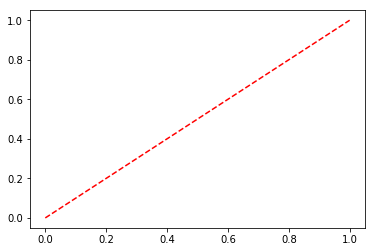

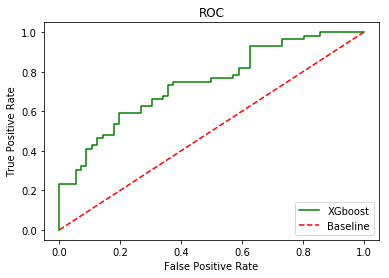

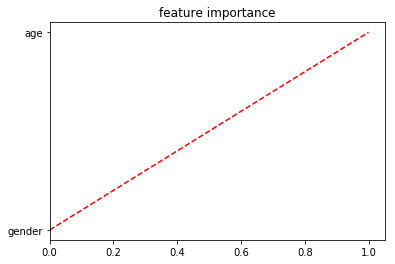

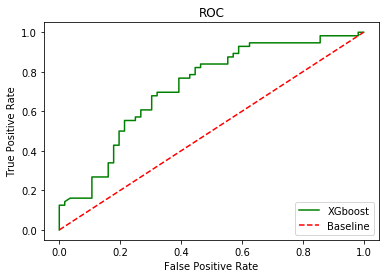

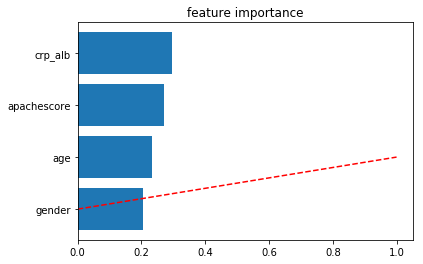

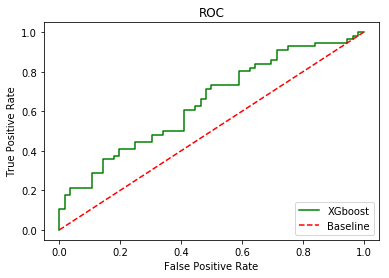

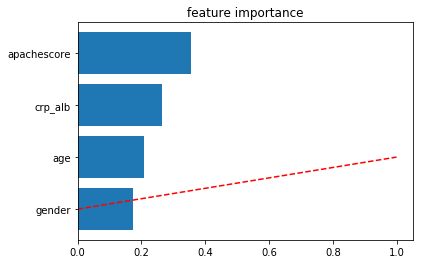

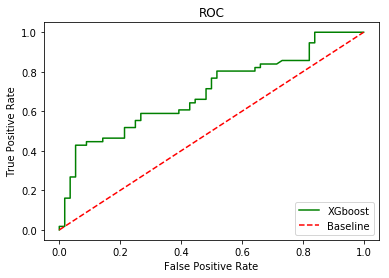

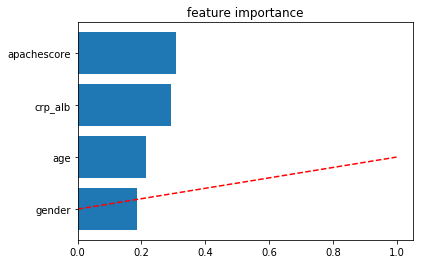

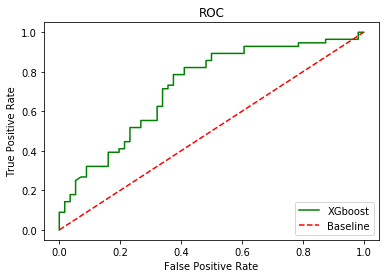

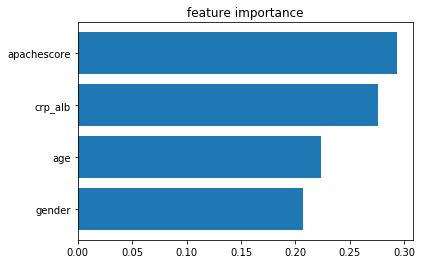

In [203]:
# crp_alb + apachescore
if __name__ == '__main__':
    time_start = time()
    #X, y, collist = clean_data()
    #collist = df.columns[:-1].values
    #X = df.iloc[:, :-1].values
    #y = df.iloc[:, -1].values
    # shuffle the train data
    #shuffle_index = np.random.permutation(len(X))
    #X, y = X[shuffle_index], y[shuffle_index]
    df_death = data[data['unitdischargestatus']==1]
    df_death['unitdischargestatus'] = 1
    df_alive = data[data['unitdischargestatus']==0]
    df_alive['unitdischargestatus'] = 0
    df = pd.concat([df_death,df_alive])
    df = df[['gender','age','apachescore','crp_alb','unitdischargestatus']]
    
    
    #del df_hii['Unnamed: 0']
   # del df_hii['index'] 
    #del df_hii['Label_HII']
    #del df_nohii['Unnamed: 0']
    #del df_nohii['index'] 
    #del df_nohii['Label_HII']
    
    #df_icu= df[df['apachescore']=='ICU']
    #df_no_icu = df[df['apachescore']!='ICU']
    #df_no_icu['apachescore'] = df_no_icu['apachescore'].astype(float)
    #df_no_icu['apachescore'] = abs(df_no_icu['apachescore'])
    #df_icu.loc[df_icu.apachescore  == 'ICU', 'apachescore'] = 70.02765
    #df = pd.concat([df_icu,df_no_icu])
    #col_list = ['bp_s_i','bp_s','hr','bun','abe','hematocrit','wbc-leukocyte','co2','creatinine','fio2','paco2',
            #'temp_degc','hemoglobin','shock_idx','age','HII']
    
    df = df.astype('float')
    
    
    #final_df = final_df[columns].astype('float')
    collist = df.columns[:-1].values
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # shuffle the train data
    shuffle_index = np.random.permutation(len(X))
    X, y = X[shuffle_index], y[shuffle_index]



    model = {
        #'logistic_regression': logistic_regression_model,
        #'svc': svc_model,
        #'random_forest': random_forest_model,
        'xgboost': xgboost_model,
        #'mlp': mlp_model,
        #'knn': knn_model
    }

    model_result = defaultdict(dict)
    for model_name, build_model in model.items():
        print('processing {0}'.format(model_name))
        scores = VAPClassifier(X, y, collist).model_performance_kfolds()

        # calc mean and std of k-fold cross validation
        for key, value in scores.items():
            value = np.array(scores[key])
            model_result[model_name][key] = [np.mean(value), np.std(value)]
    pprint(model_result)

    time_end = time()
    print('process in {0} s'.format(time_end - time_start))

    plt.show()
    

In [190]:
def clean_data():
    col = {
        'gender': 'gender',
        'age': 'age',
        'apachescore': 'apachescore'
    }
    df_death = data[data['unitdischargestatus']==1]
    df_death['unitdischargestatus'] = 1
    df_alive = data[data['unitdischargestatus']==0]
    df_alive['unitdischargestatus'] = 0
    df = pd.concat([df_death,df_alive])
    df = df[['gender','age','apachescore','unitdischargestatus']]
    
    
    #del df_hii['Unnamed: 0']
   # del df_hii['index'] 
    #del df_hii['Label_HII']
    #del df_nohii['Unnamed: 0']
    #del df_nohii['index'] 
    #del df_nohii['Label_HII']
    
    #df_icu= df[df['apachescore']=='ICU']
    #df_no_icu = df[df['apachescore']!='ICU']
    #df_no_icu['apachescore'] = df_no_icu['apachescore'].astype(float)
    #df_no_icu['apachescore'] = abs(df_no_icu['apachescore'])
    #df_icu.loc[df_icu.apachescore  == 'ICU', 'apachescore'] = 70.02765
    #df = pd.concat([df_icu,df_no_icu])
    #col_list = ['bp_s_i','bp_s','hr','bun','abe','hematocrit','wbc-leukocyte','co2','creatinine','fio2','paco2',
            #'temp_degc','hemoglobin','shock_idx','age','HII']
    
    df = df.astype('float')
    
    #final_df = final_df[columns].astype('float')
    #collist = df.columns[:-1].values
    #X = df.iloc[:, :-1].values
    #y = df.iloc[:, -1].values
    #final_df = final_df[columns].astype('float')
    collist = df.columns[:-1].values
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # shuffle the train data
    shuffle_index = np.random.permutation(len(X))
    X, y = X[shuffle_index], y[shuffle_index]

    return X, y, collist


processing xgboost
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.89it/s, best loss: -0.5789620535714286]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.45it/s, best loss: -0.5845424107142858]
optimize hyper-parameter via bayes search
100%|████████████████████████████████████████████████████| 4/4 [00:00<00:00, 14.07it/s, best loss: -0.5620814732142858]
optimize hyper-parameter via bayes search
100%|███████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 23.40it/s, best loss: -0.5]
optimize hyper-parameter via bayes search
100%|██████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.76it/s, best loss: -0.6650390625]
optimize hyper-parameter via bayes search
100%|█████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 15.34it/s, best loss: -0.6171875]
optimize 

TypeError: 'module' object is not callable

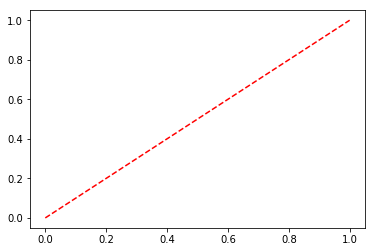

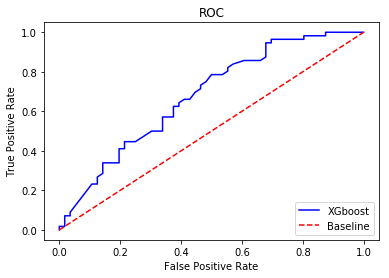

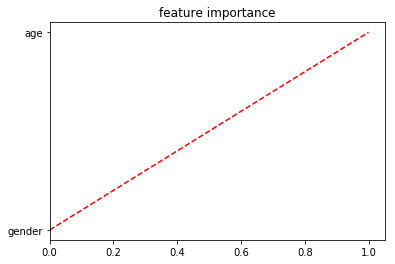

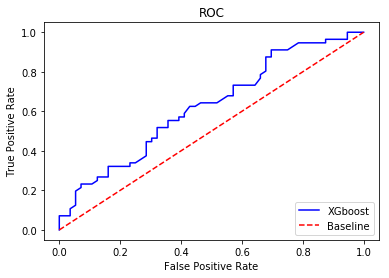

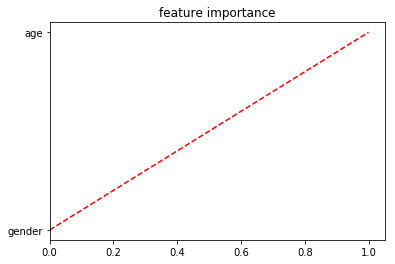

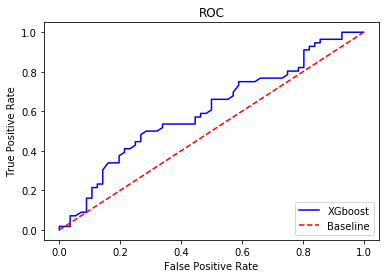

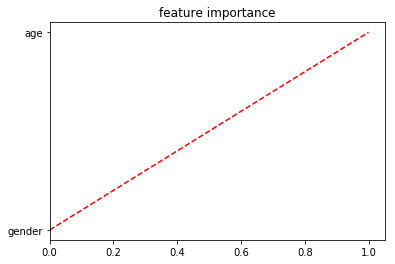

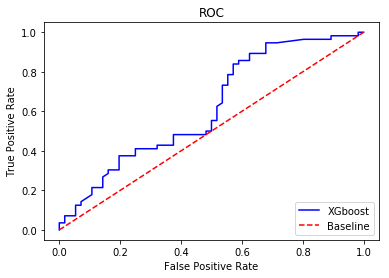

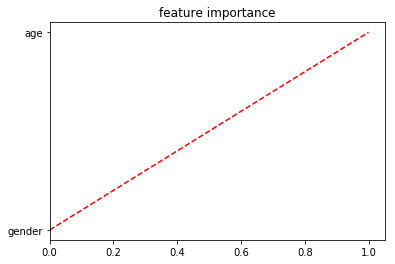

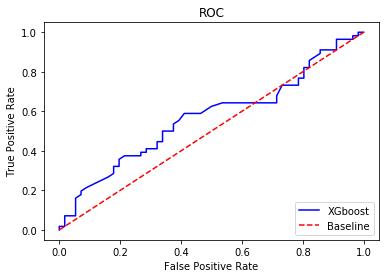

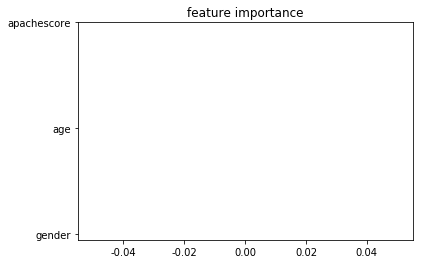

In [143]:
# only apachescore
if __name__ == '__main__':
    #time_start = time()
    #X, y, collist = clean_data()
    #collist = df.columns[:-1].values
    #X = df.iloc[:, :-1].values
    #y = df.iloc[:, -1].values
    # shuffle the train data
    #shuffle_index = np.random.permutation(len(X))
    #X, y = X[shuffle_index], y[shuffle_index]
    df_death = data[data['unitdischargestatus']==1]
    df_death['unitdischargestatus'] = 1
    df_alive = data[data['unitdischargestatus']==0]
    df_alive['unitdischargestatus'] = 0
    df = pd.concat([df_death,df_alive])
    df = df[['gender','age','apachescore','unitdischargestatus']]
    
    
    #del df_hii['Unnamed: 0']
   # del df_hii['index'] 
    #del df_hii['Label_HII']
    #del df_nohii['Unnamed: 0']
    #del df_nohii['index'] 
    #del df_nohii['Label_HII']
    
    df_icu= df[df['apachescore']=='ICU']
    df_no_icu = df[df['apachescore']!='ICU']
    df_no_icu['apachescore'] = df_no_icu['apachescore'].astype(float)
    df_no_icu['apachescore'] = abs(df_no_icu['apachescore'])
    df_icu.loc[df_icu.apachescore  == 'ICU', 'apachescore'] = 70.02765
    df = pd.concat([df_icu,df_no_icu])
    #col_list = ['bp_s_i','bp_s','hr','bun','abe','hematocrit','wbc-leukocyte','co2','creatinine','fio2','paco2',
            #'temp_degc','hemoglobin','shock_idx','age','HII']
    
    df = df.astype('float')
    
    
    #final_df = final_df[columns].astype('float')
    collist = df.columns[:-1].values
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values
    # shuffle the train data
    shuffle_index = np.random.permutation(len(X))
    X, y = X[shuffle_index], y[shuffle_index]



    model = {
        #'logistic_regression': logistic_regression_model,
        #'svc': svc_model,
        #'random_forest': random_forest_model,
        'xgboost': xgboost_model,
        #'mlp': mlp_model,
        #'knn': knn_model
    }

    model_result = defaultdict(dict)
    for model_name, build_model in model.items():
        print('processing {0}'.format(model_name))
        scores = VAPClassifier(X, y, collist).model_performance_kfolds()

        # calc mean and std of k-fold cross validation
        for key, value in scores.items():
            value = np.array(scores[key])
            model_result[model_name][key] = [np.mean(value), np.std(value)]
    pprint(model_result)

    time_end = time()
    print('process in {0} s'.format(time_end - time_start))

    plt.show()
    